In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

In [2]:
google = pd.read_csv('google.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


**Let's get a description of the given dataframe**

**Date**  : This is the date of trading

**Open**  : Price at which security first trades

**High**  : Highest Price of the trading day

**Low**   : Lowest Price of the trading day

**Close** : Last Price the stock traded during the trading day

**Adj Close** : Price that is adjusts Coroporate Actions on Closing Price

**Volume** : Number of Shares that changed hands during the trading day

In [3]:
## Creating a function "Preprocessing" to get the entire summary of out Time Series data

def Preprocessing(data):
    print("Shape of the data: ",google.shape)
    print("Columns present in the data: ",google.columns)
    print("Data type of each column: ",google.dtypes)
    print("Number of missing values in each column: ",google.isnull().sum())
    print("Number of unique values in each column: ",google.nunique())
    print("Number of duplicate values in the data: ",google.duplicated().sum())
    print("Basic statistics of the data: ",google.describe())
    print("Number of unique values in each column: ",google.nunique())
    print("Number of missing values in each column: ",google.isnull().sum())
    print("Number of duplicate values in the data: ",google.duplicated().sum())
    print("Basic statistics of the data: ",google.describe())
    
#call the function
Preprocessing(google)

Shape of the data:  (3272, 6)
Columns present in the data:  Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Data type of each column:  Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Number of missing values in each column:  Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Number of unique values in each column:  Open         3204
High         3184
Low          3215
Close        3239
Adj Close    3239
Volume       3163
dtype: int64
Number of duplicate values in the data:  0
Basic statistics of the data:                Open         High          Low        Close    Adj Close  \
count  3272.000000  3272.000000  3272.000000  3272.000000  3272.000000   
mean     49.161187    49.650301    48.653316    49.160898    49.160898   
std      35.810449    36.216443    35.387644    35.804094    35.804094   
min      10.96871

## Basic Analysis of the Data

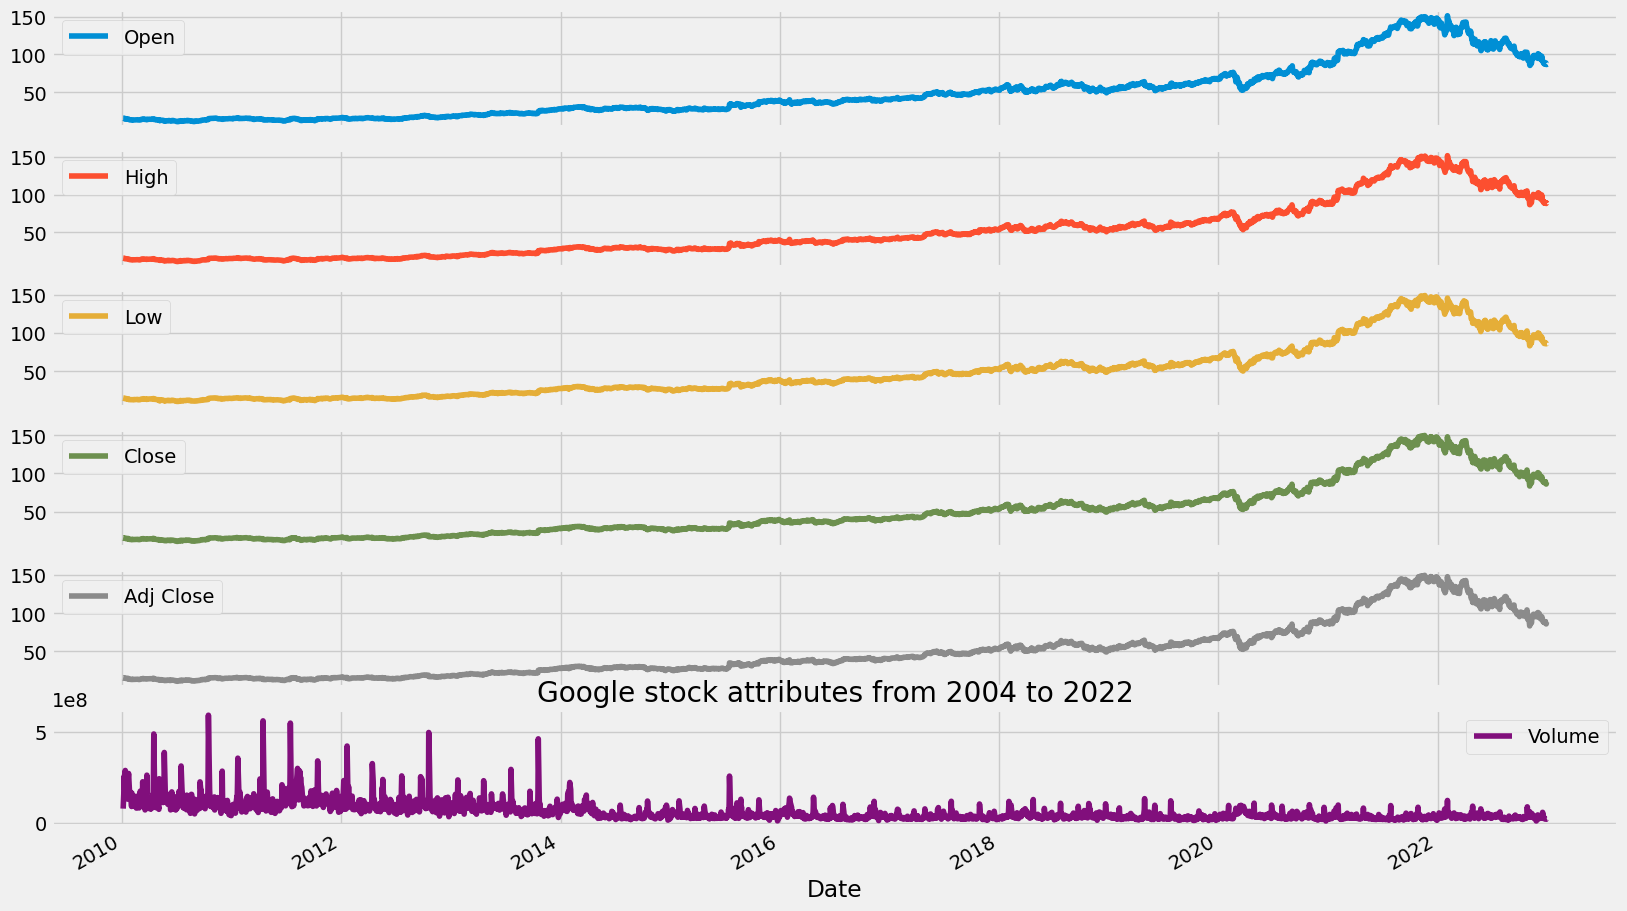

In [4]:
google['2004':'2022'].plot(subplots=True, figsize=(18,12))
plt.title('Google stock attributes from 2004 to 2022')
plt.savefig('stocks.png')
plt.show()

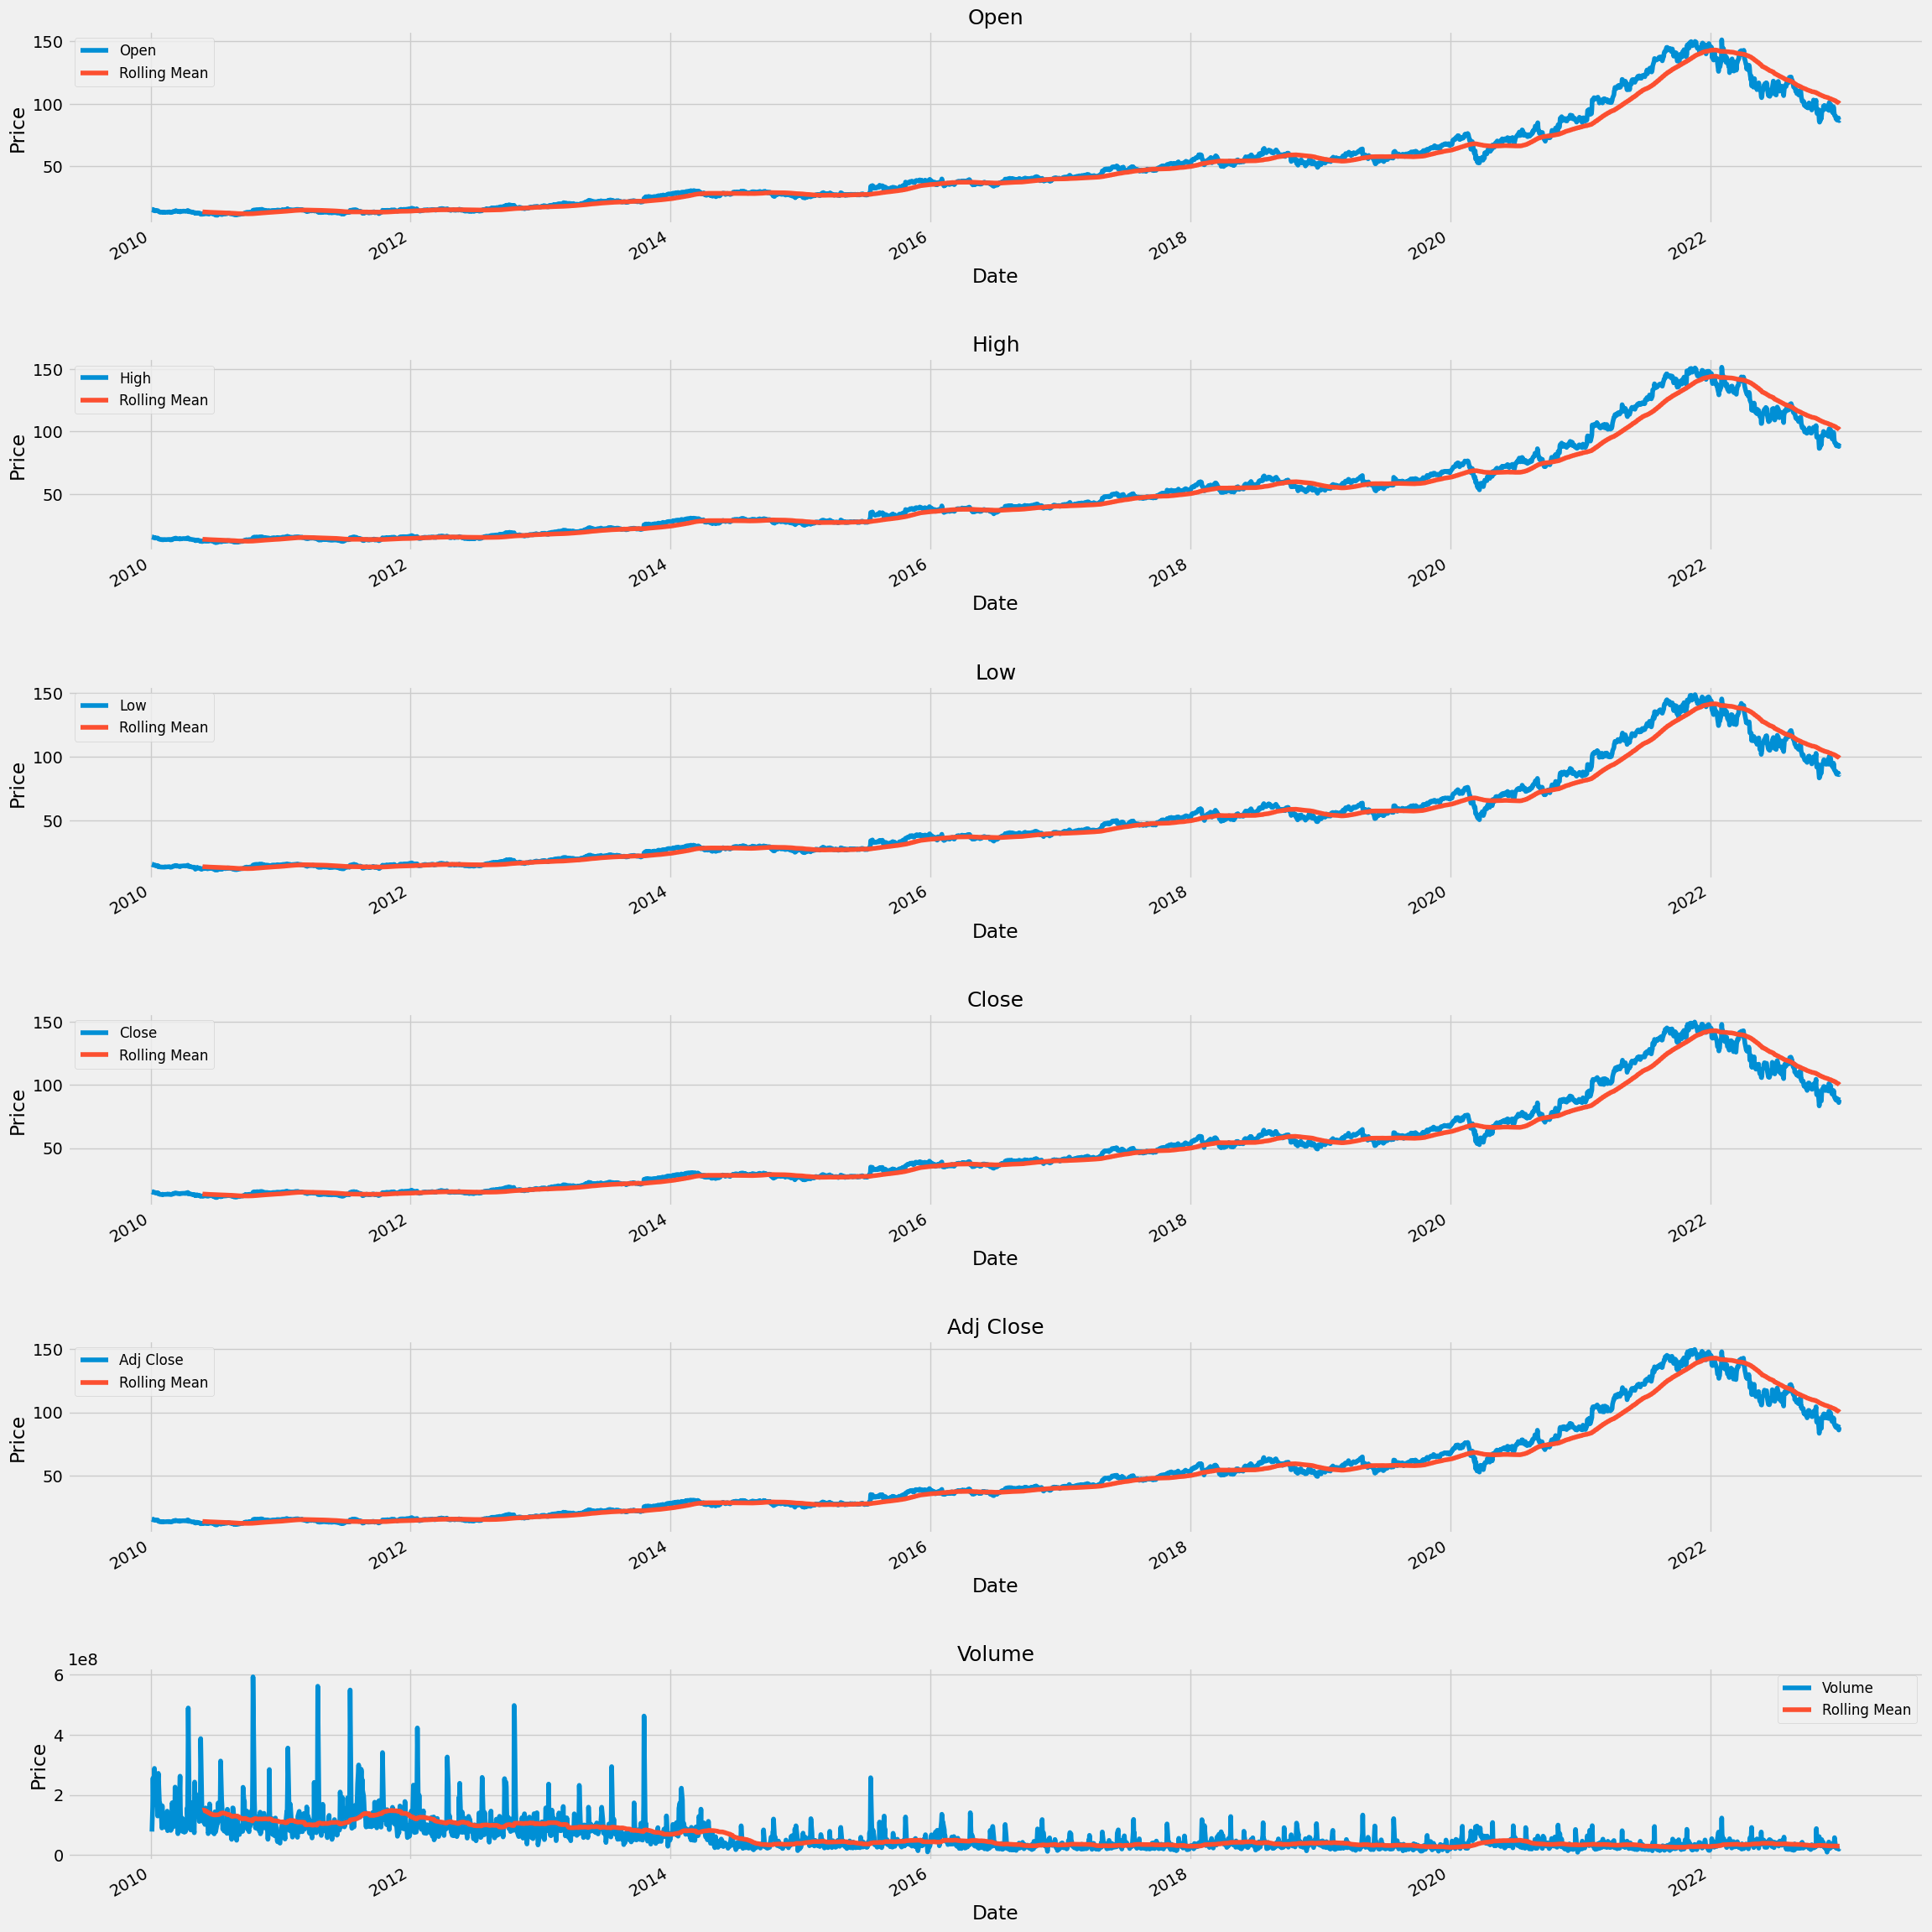

In [5]:
col_names = google.columns

fig = plt.figure(figsize=(24, 24))

for i in range(6):
    ax = fig.add_subplot(6, 1, i+1)
    ax.plot(google.iloc[:, i], label=col_names[i])
    google.iloc[:, i].rolling(100).mean().plot(label='Rolling Mean', ax=ax)  # Plot rolling mean on the same axis
    ax.set_title(col_names[i], fontsize=18)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.patch.set_edgecolor('black')
    ax.legend(prop={'size': 12})  # Use ax.legend() to set legend for each subplot

fig.tight_layout(pad=3.0)

plt.show()

In [6]:
import seaborn as sns

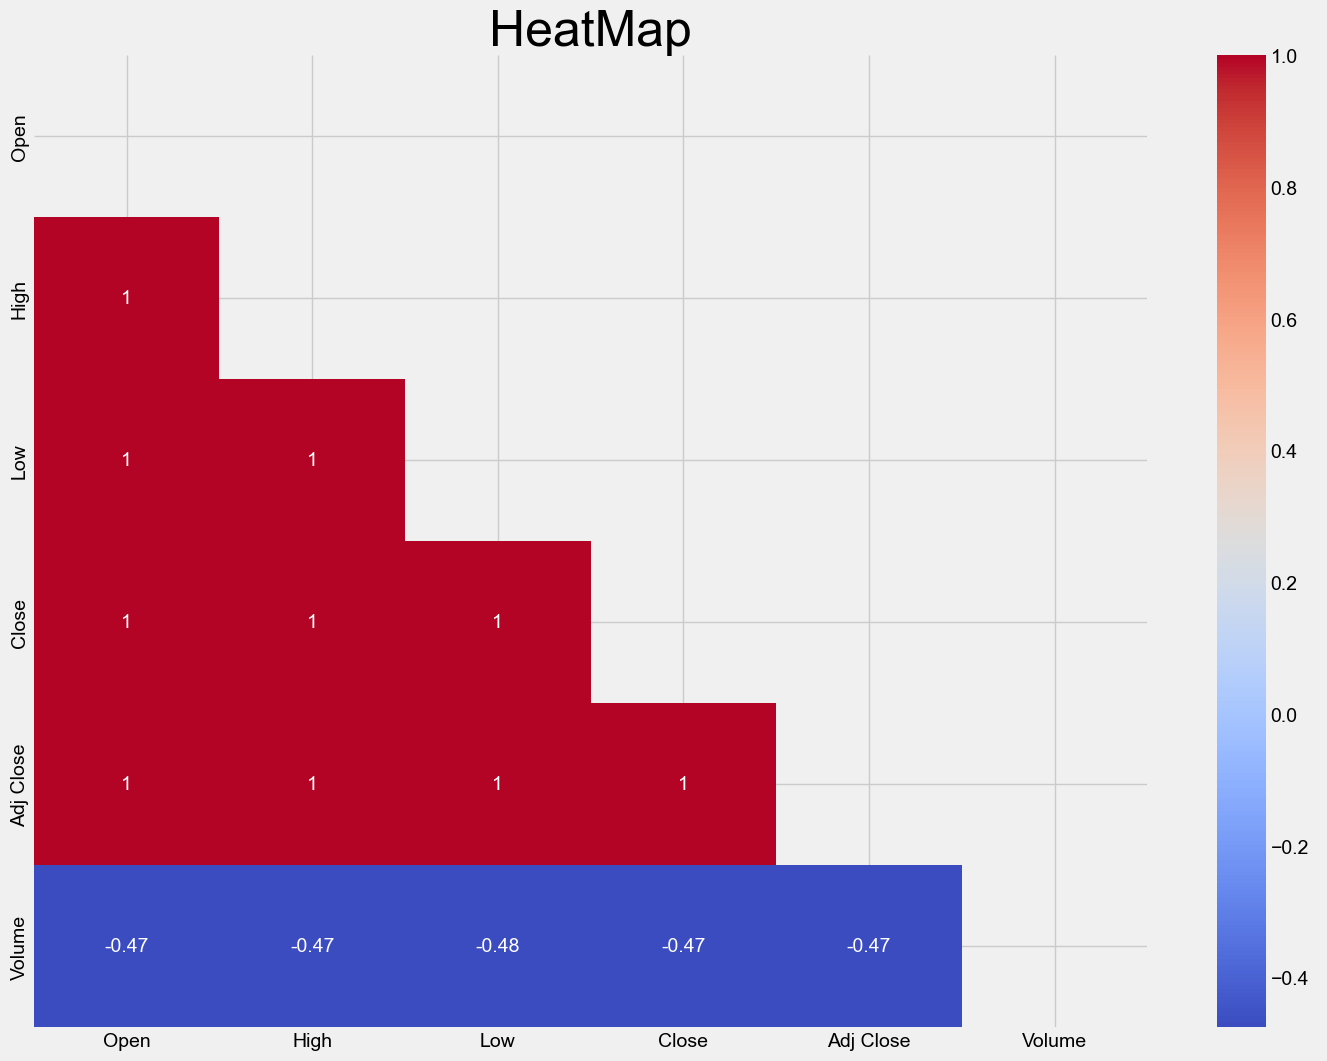

In [7]:
##HeatMap to Verify Multicollinearity between Features
fig = plt.figure(figsize=(16,12))
matrix = np.triu(google.corr())
ax = sns.heatmap(google.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.show()

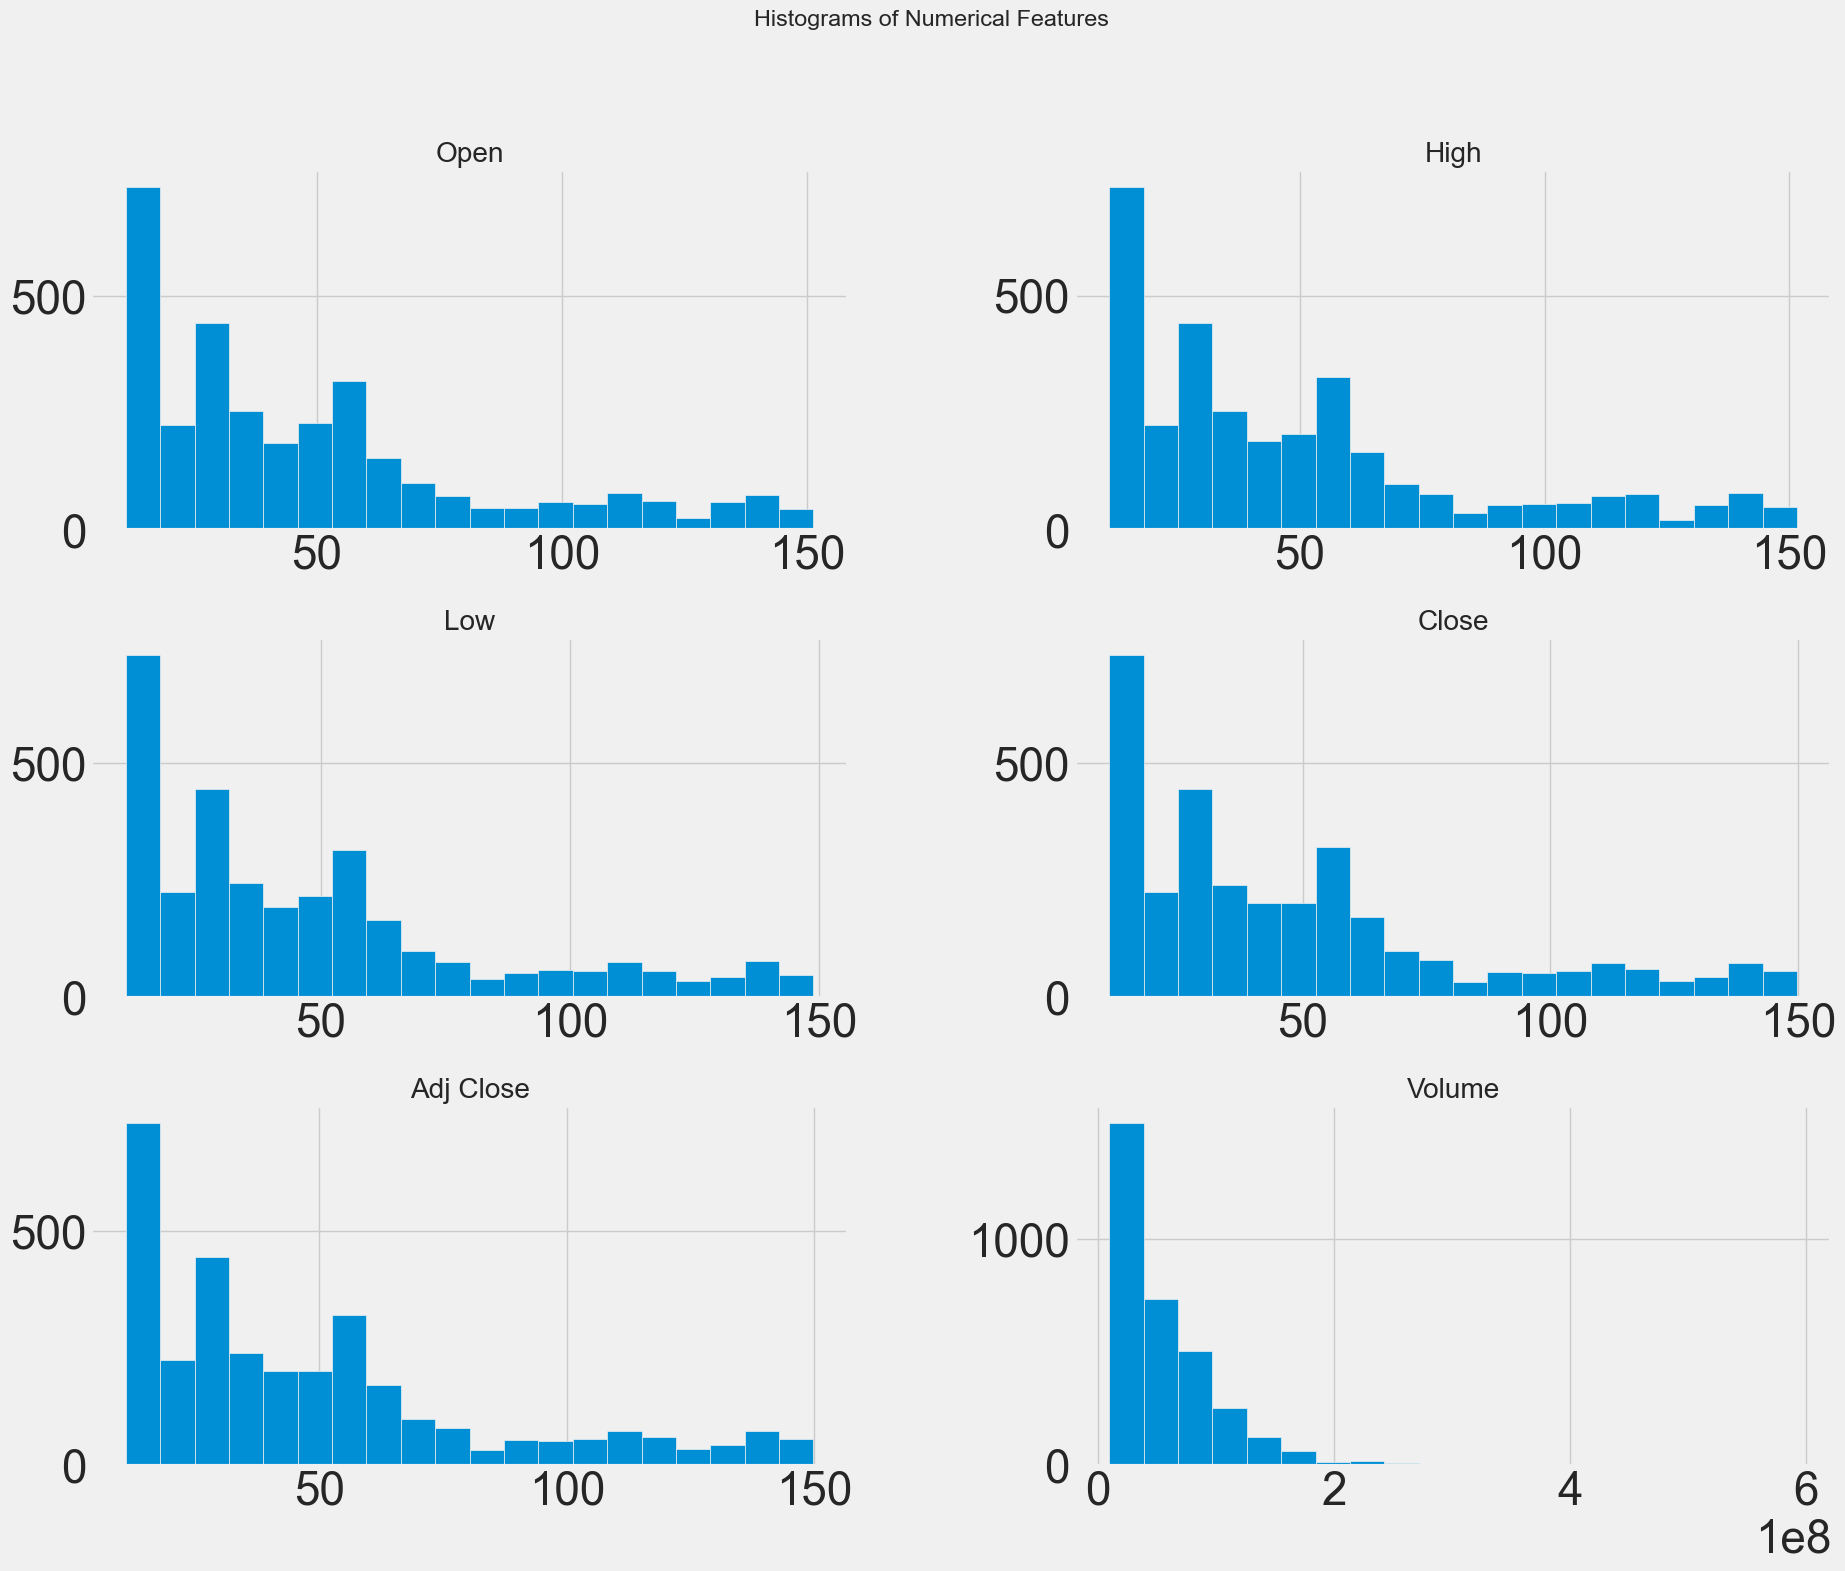

In [8]:
numerical_cols = google.select_dtypes(include=['number']).columns

# Plotting histograms for numerical features
google[numerical_cols].hist(figsize=(20, 16), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.style.use('fivethirtyeight')
plt.show()

### Feature Selection

We can eliminate features like Open,Low, High Close automatically as they are high multicollinear with Adj Close .

We consider Adj Close as our target variables as it accounts for all corporate decisions like stock split and dividents.

In [9]:
##Data after feature selection
data_feature_selected = google.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

### Resampling

- **Resampling the data to check out some analysis month wise**

In [10]:
## Resampling data to monthly 
monthly_mean = data_feature_selected['Adj Close'].resample('M').mean()

In [11]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Adj Close
Date,
2010-01-31,14.479506
2010-02-28,13.385715
2010-03-31,14.039790
2010-04-30,13.940500
2010-05-31,12.445771
...,...
2022-08-31,116.258695
2022-09-30,103.330000
2022-10-31,98.878571


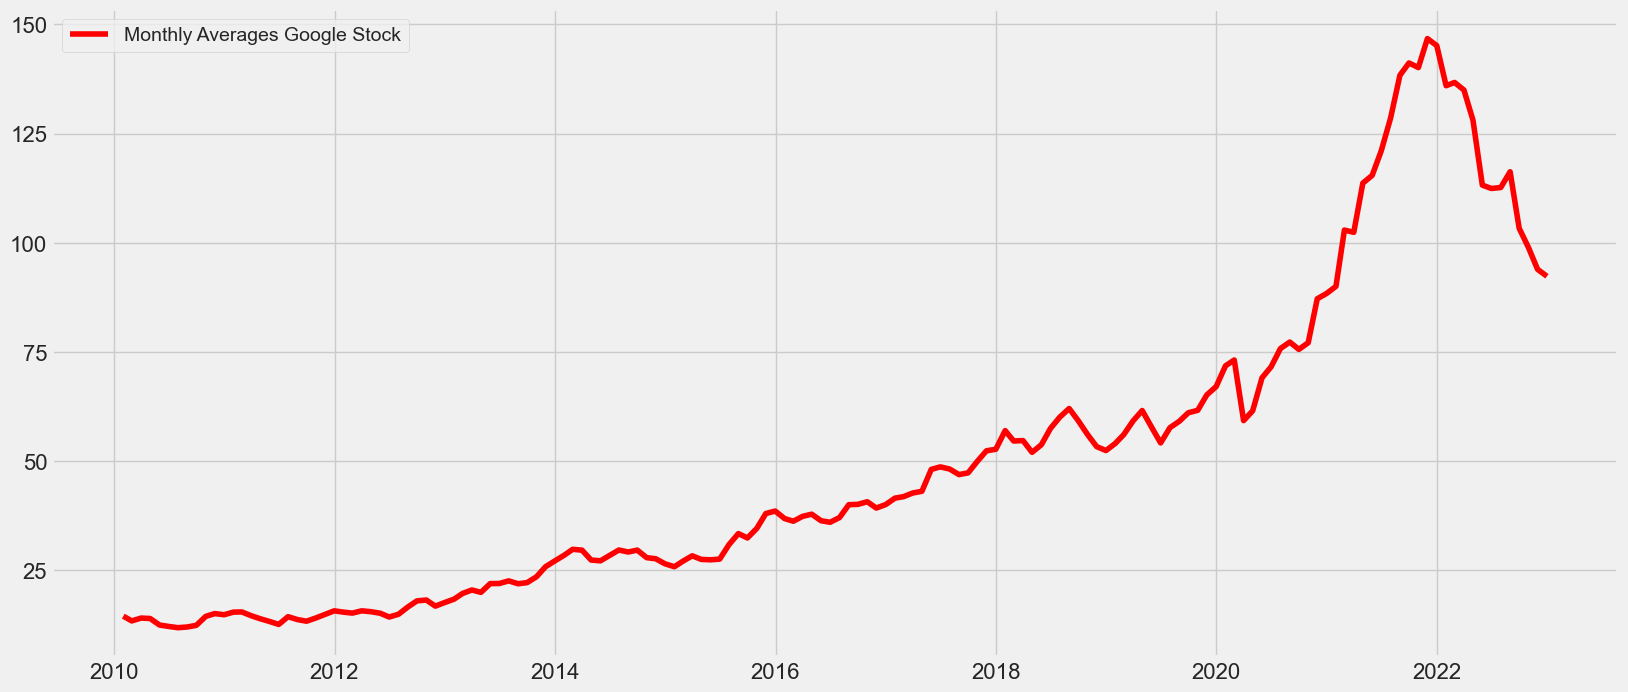

In [12]:
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Adj Close'],label='Monthly Averages Google Stock', color='red')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 14})
plt.show()

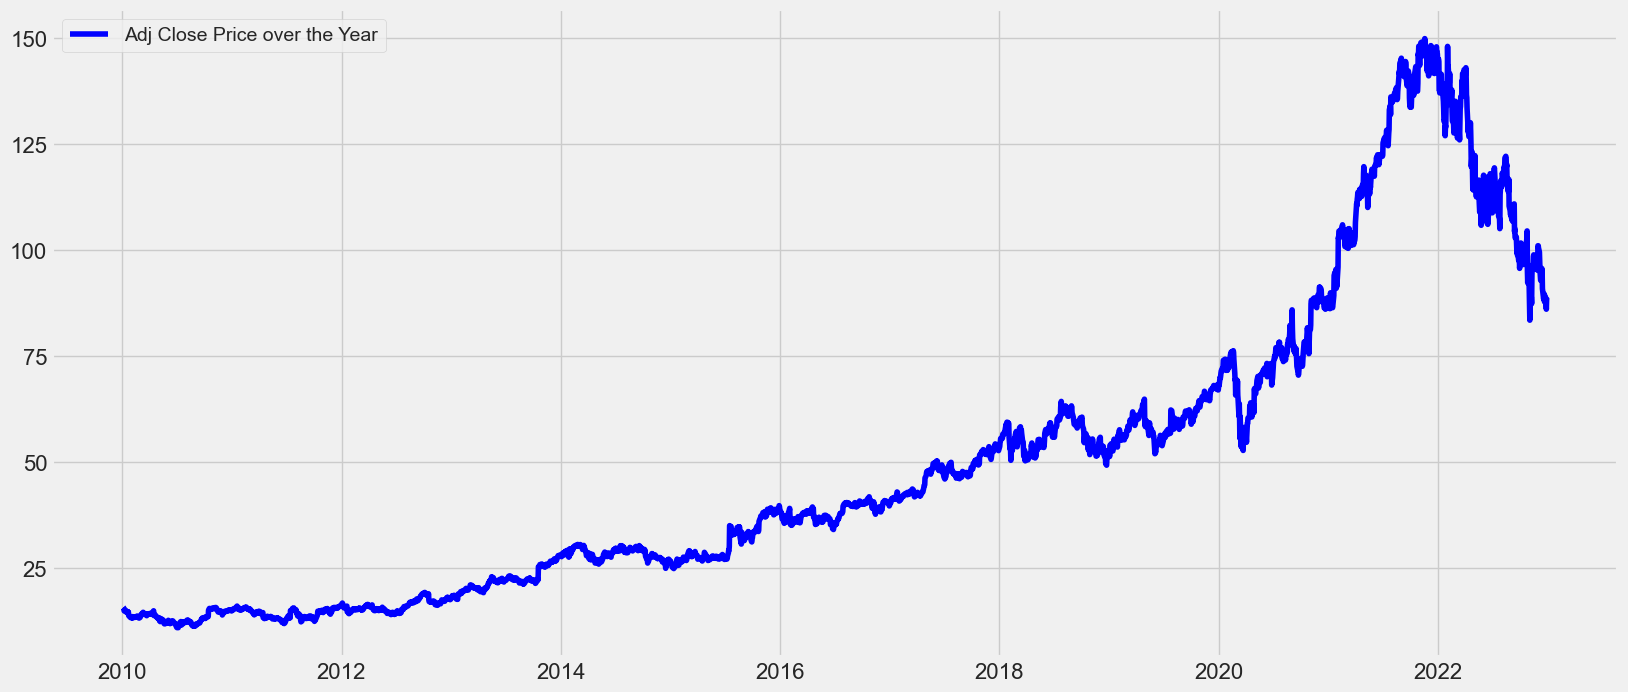

In [13]:
fig = plt.figure(figsize=(18,8))
plt.plot(google['Adj Close'],label='Adj Close Price over the Year', color='blue')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 14})
plt.show()

## Exploratory Data Analysis(EDA)

In [14]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

,Adj Close,Year,Month,dayofweek,quarter
Date,,,,,
2010-01-31,14.479506,2010,January,Sunday,1
2010-02-28,13.385715,2010,February,Sunday,1
2010-03-31,14.039790,2010,March,Wednesday,1
2010-04-30,13.940500,2010,April,Friday,2
2010-05-31,12.445771,2010,May,Monday,2
...,...,...,...,...,...
2022-08-31,116.258695,2022,August,Wednesday,3
2022-09-30,103.330000,2022,September,Friday,3
2022-10-31,98.878571,2022,October,Monday,4


In [15]:
google['Year'] = google.index.year
google['Month'] = google.index.strftime('%B')
google['dayofweek'] = google.index.strftime('%A')
google['quarter'] = google.index.quarter
google

,Open,High,Low,Close,Adj Close,Volume,Year,Month,dayofweek,quarter
Date,,,,,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752,2010,January,Monday,1
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812,2010,January,Tuesday,1
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852,2010,January,Wednesday,1
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428,2010,January,Thursday,1
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028,2010,January,Friday,1
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000,2022,December,Friday,4
2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300,2022,December,Tuesday,4
2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,19523200,2022,December,Wednesday,4


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.015, '0.015'),
  Text(0, 0.02, '0.020'),
  Text(0, 0.025, '0.025'),
  Text(0, 0.03, '0.030'),
  Text(0, 0.035, '0.035'),
  Text(0, 0.04, '0.040')])

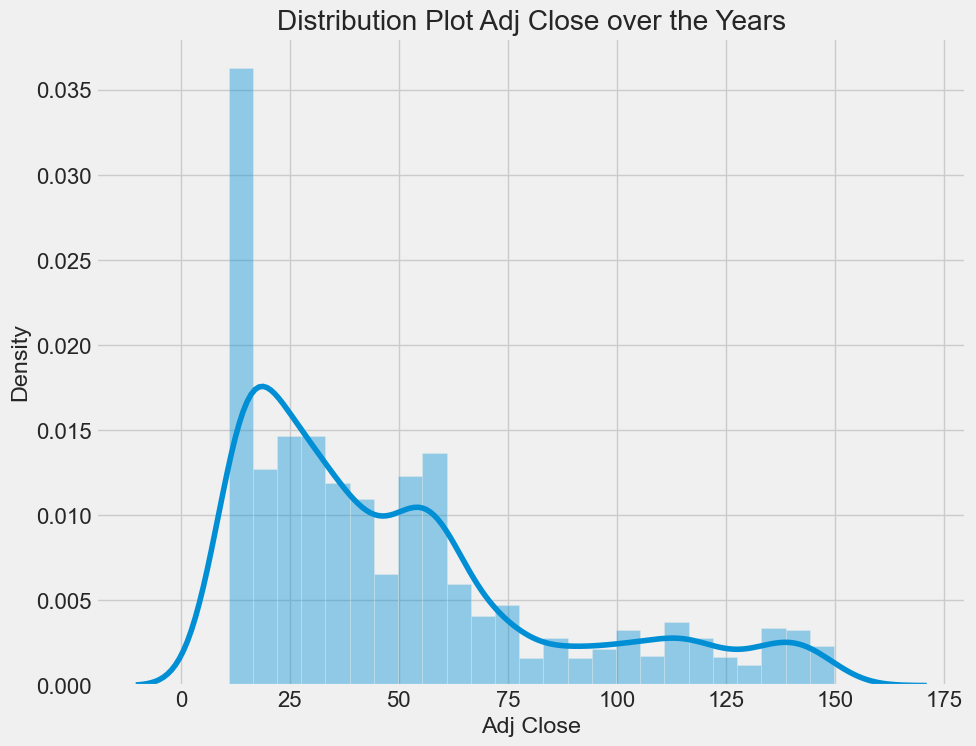

In [16]:
### Checking the distribution of the data
fig = plt.figure(figsize=(10,8))
sns.distplot(google['Adj Close']).set_title("Distribution Plot Adj Close over the Years")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

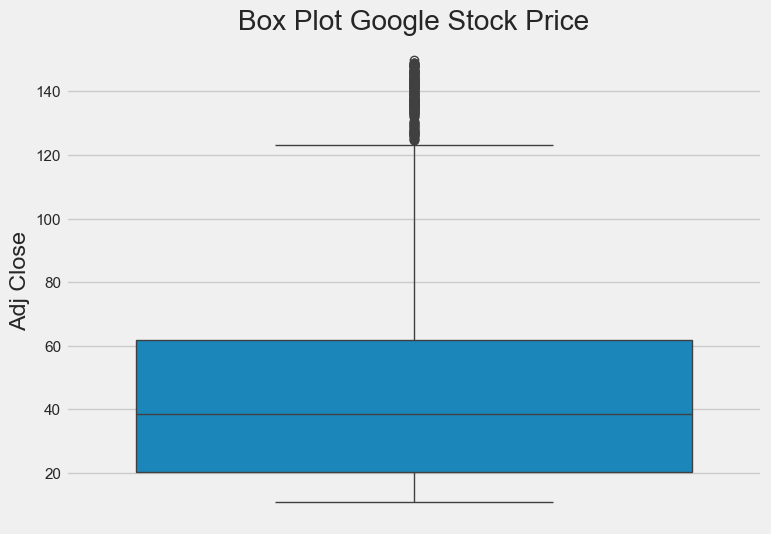

In [17]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(google['Adj Close']).set_title('Box Plot Google Stock Price')
plt.style.use('fivethirtyeight')

 - **The distribution of the data is right skew**
 - **Outlier towards the higher end around the stock price of 130**

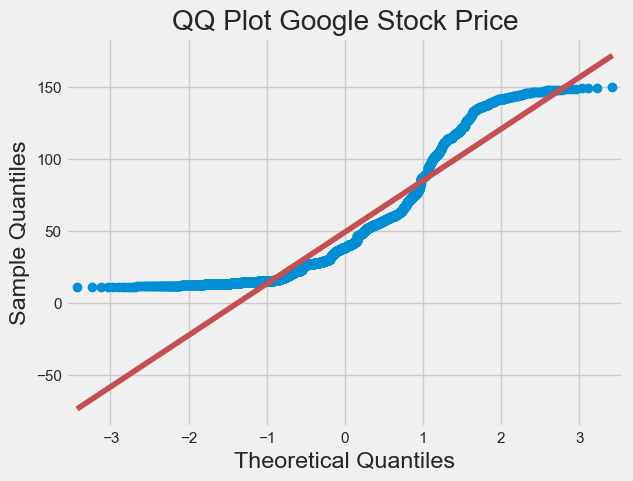

In [18]:
qq_plot = sm.qqplot(google['Adj Close'], line='s')
plt.title('QQ Plot Google Stock Price')
plt.style.use('fivethirtyeight')
plt.show()

- **Heavy Tailed Distribution-Curve at Extremities**
- **Shows extent of both right and left skews**
- **Shows Distribution is Not following Gaussian Normal Distribution**

In [19]:
print('Skewness of Distribution is ',monthly_data['Adj Close'].skew())
print('Kurtosis of Distribution is ',monthly_data['Adj Close'].kurtosis())

Skewness of Distribution is  1.1624310625093748
Kurtosis of Distribution is  0.4974746294677179


**Stock Price is Heavily skewed -Right tailed Skewness**

Text(0.5, 1.0, 'Box Plots Year Wise-Google Stock Price')

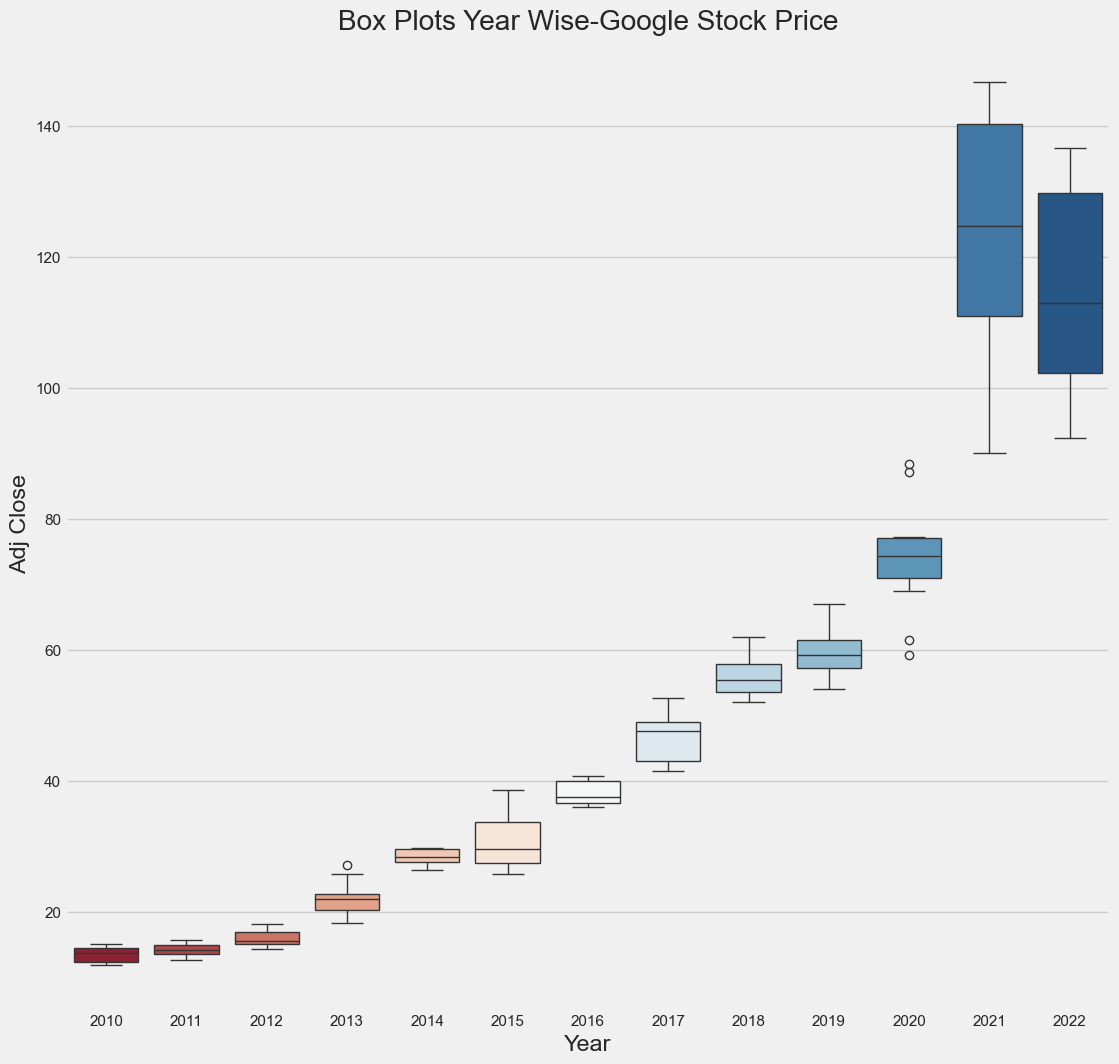

In [20]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(x=monthly_data['Year'],y=monthly_data['Adj Close'],palette='RdBu')
plt.style.use('fivethirtyeight')
ax.set_title('Box Plots Year Wise-Google Stock Price')

- **Outliers Present in Year 2013 and 2020**
- **Lot of Variability in Years 2015, 2017, 2020-22**
- **2021 most volatile year among all years**
- **Upward Rising Trend is shown**

In [21]:
## Some Monthly Analysis
from scipy import stats 

group_by_yr = []
list_years = monthly_data['Year'].unique()
dict_IQR = {}

for yr in list_years:
    group_by_yr.append('df' + str(yr))

for yr in list_years:
    group_by_yr.append(monthly_data[monthly_data['Year'] == yr]['Adj Close'])
    dict_IQR[str(yr)] = stats.iqr(monthly_data[monthly_data['Year'] == yr]['Adj Close'])

print(dict_IQR)

{'2010': 2.1167459298530407, '2011': 1.4089279906314687, '2012': 1.8084355959415621, '2013': 2.45615620172925, '2014': 2.0422515068922316, '2015': 6.230040611850647, '2016': 3.3094278151901477, '2017': 6.016590491652799, '2018': 4.278323286597178, '2019': 4.330588246552644, '2020': 6.1827924675324795, '2021': 29.415835869047598, '2022': 27.580784363586957}


Text(0, 0.5, 'InterQuartile Range')

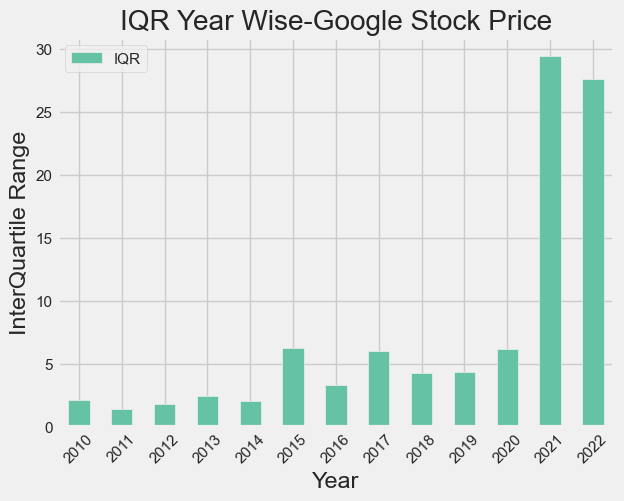

In [22]:
IQR_df = pd.DataFrame(dict_IQR.items(),columns=['Year','IQR'])
IQR_df.index = IQR_df['Year']
IQR_df.plot(kind='bar', cmap='Set2')
plt.xticks(rotation=45)
plt.style.context('fivethirtyeight')
plt.title('IQR Year Wise-Google Stock Price')
plt.ylabel('InterQuartile Range')

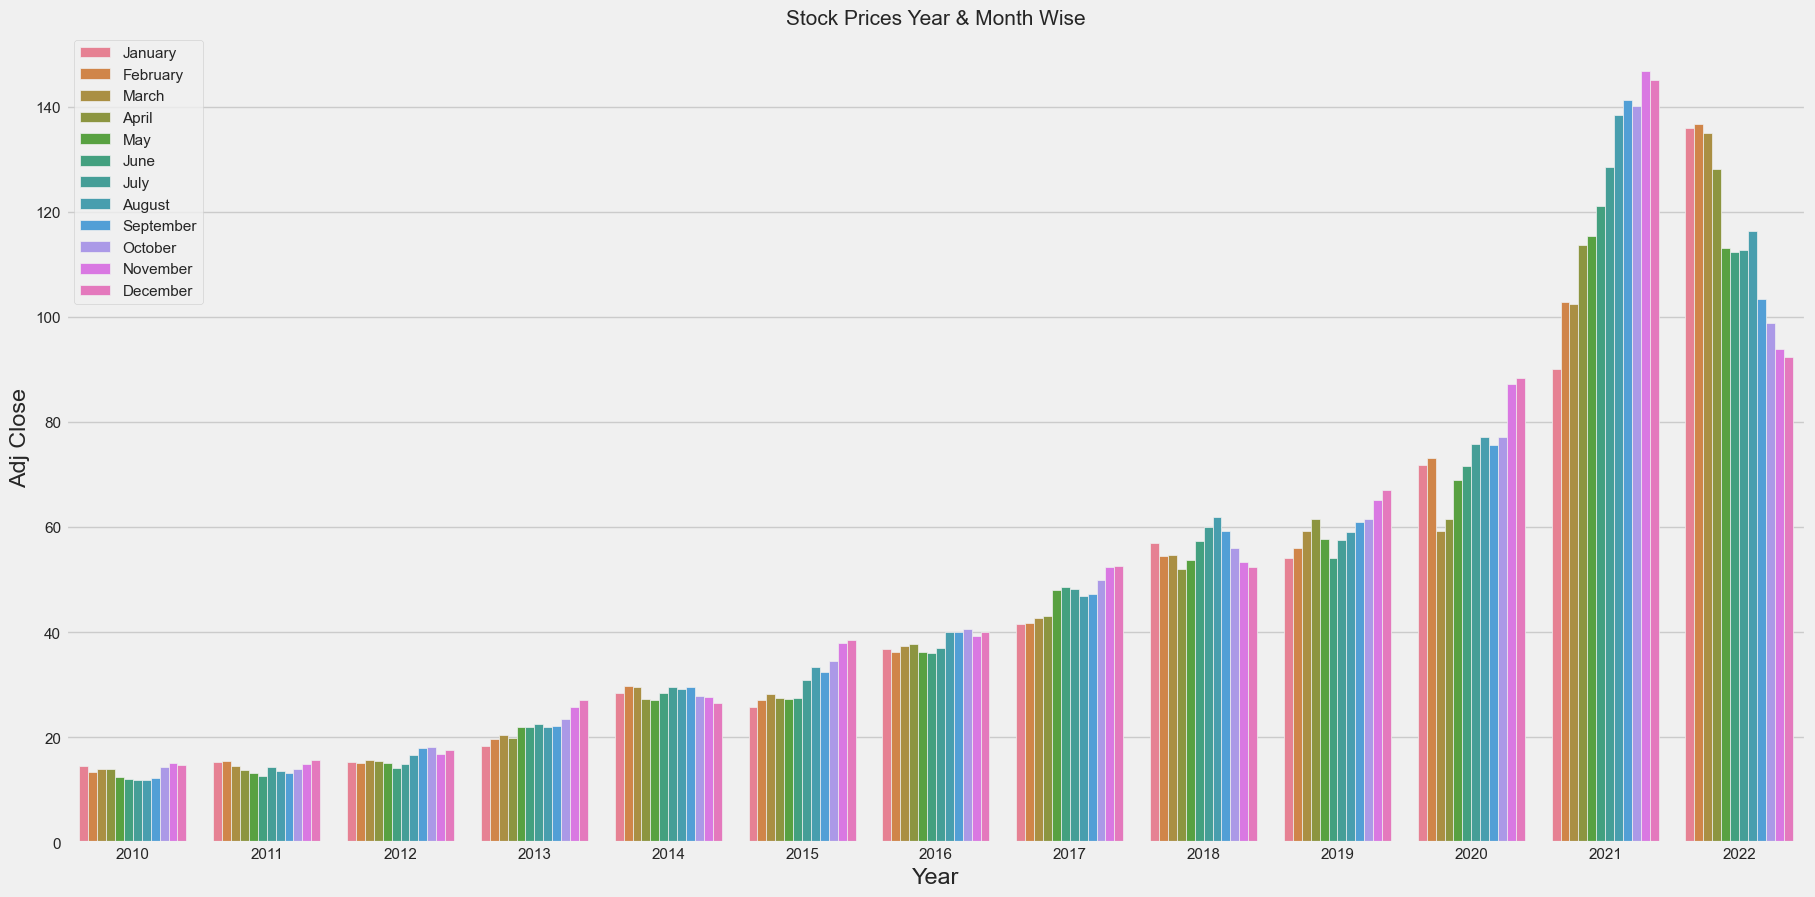

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("rocket", 4)
a = sns.barplot(x="Year", y="Adj Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.style.context('fivethirtyeight')
plt.show()

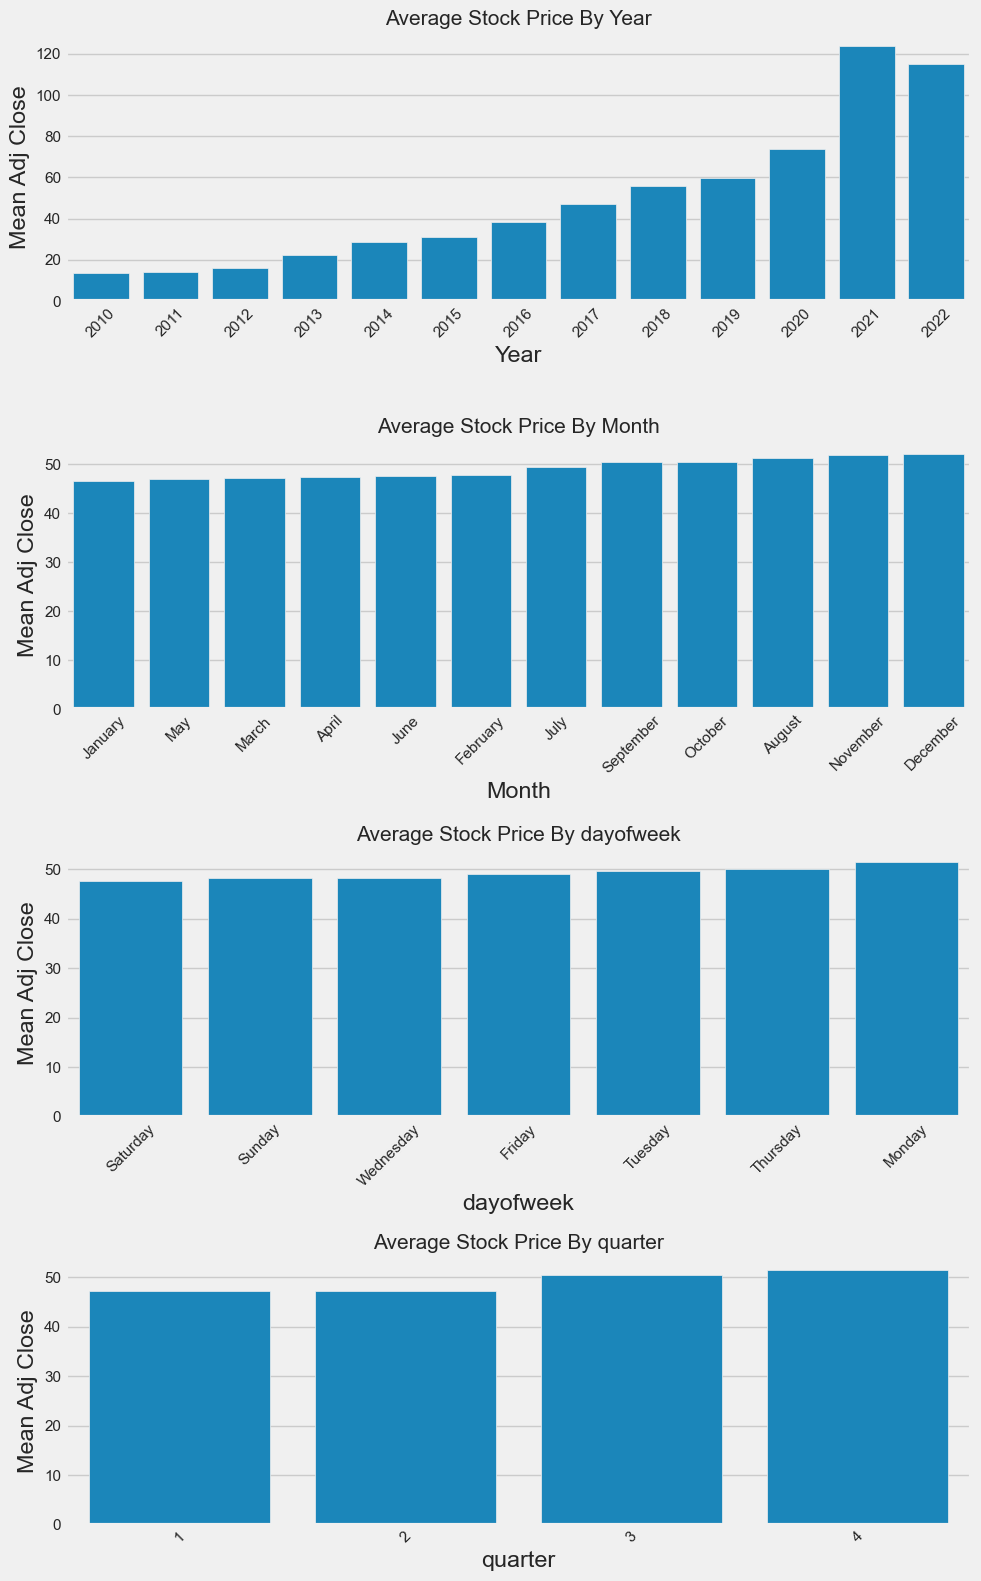

In [24]:
fig = plt.figure(figsize=(10,16))
fig.set_size_inches(10,16)
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Adj Close"].mean()).reset_index().sort_values('Adj Close')
  sns.barplot(data=Aggregated,x=str(i),y="Adj Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Adj Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)

plt.style.context('fivethirtyeight')
plt.tight_layout(pad=1)

- **According to Mean price by Years the stocks are increasing**
- **Average Stock Price is lower at start of the week in comparision to the end of the week.**
- **The Average Price is Highest in the Month of November.**
- **Q4 is the best for Apple according to average stock price.**

### ETS Decomposition of the Time Series Data

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

<Figure size 2000x1600 with 0 Axes>

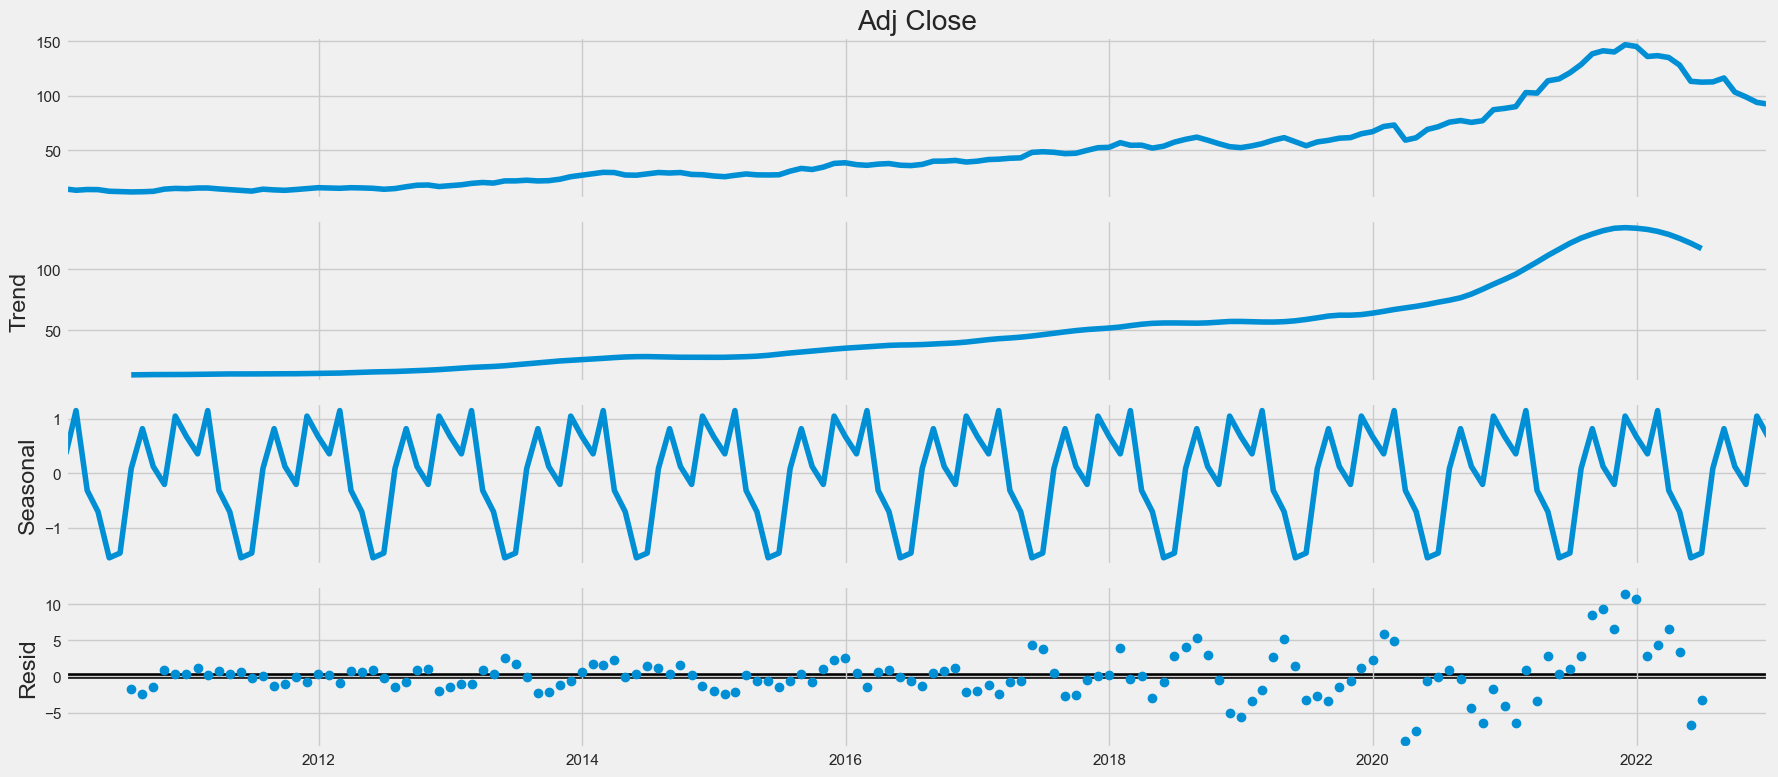

In [26]:
rcParams['figure.figsize'] = (18, 8)
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Adj Close'],model='additive',period=12)
decomposed_series.plot()
plt.style.context('fivethirtyeight')
plt.show()

**Inferences by Decomposition**

- **Trend**: Overall the trend is Upward
- **Seasonality**: There appears to be seasonality

### Moving Averages

In [27]:
monthly_data['EWMA-3'] = monthly_data['Adj Close'].ewm(span = 3).mean()

In [28]:
monthly_data['EWMA-6'] = monthly_data['Adj Close'].ewm(span = 6).mean()

In [29]:
monthly_data['EWMA-12'] = monthly_data['Adj Close'].ewm(span = 12).mean()

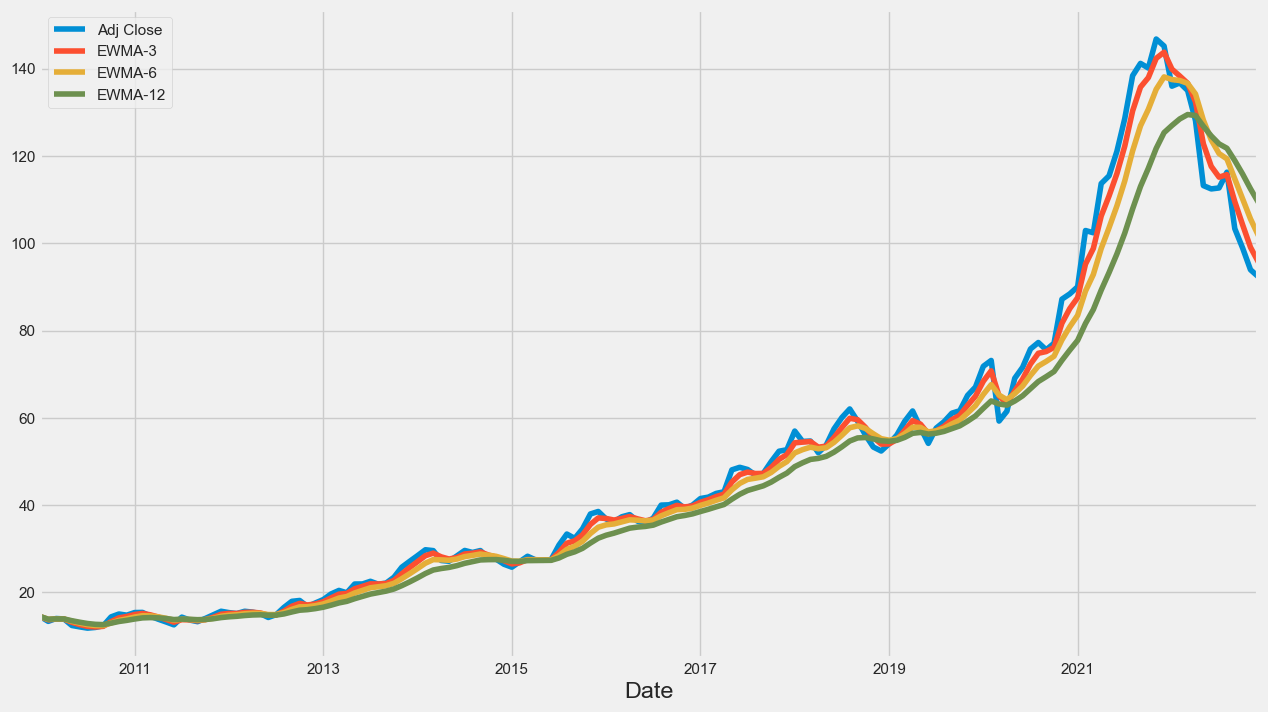

In [30]:
monthly_data[['Adj Close', 'EWMA-3','EWMA-6', 'EWMA-12']].plot(figsize=(14, 8));

### Rolling Statistics

In [31]:
rolling_window = 30     ## 30 days

# Computing rolling mean and standard deviation
rolling_mean = google['Adj Close'].rolling(window=rolling_window).mean()
rolling_std = google['Adj Close'].rolling(window=rolling_window).std()

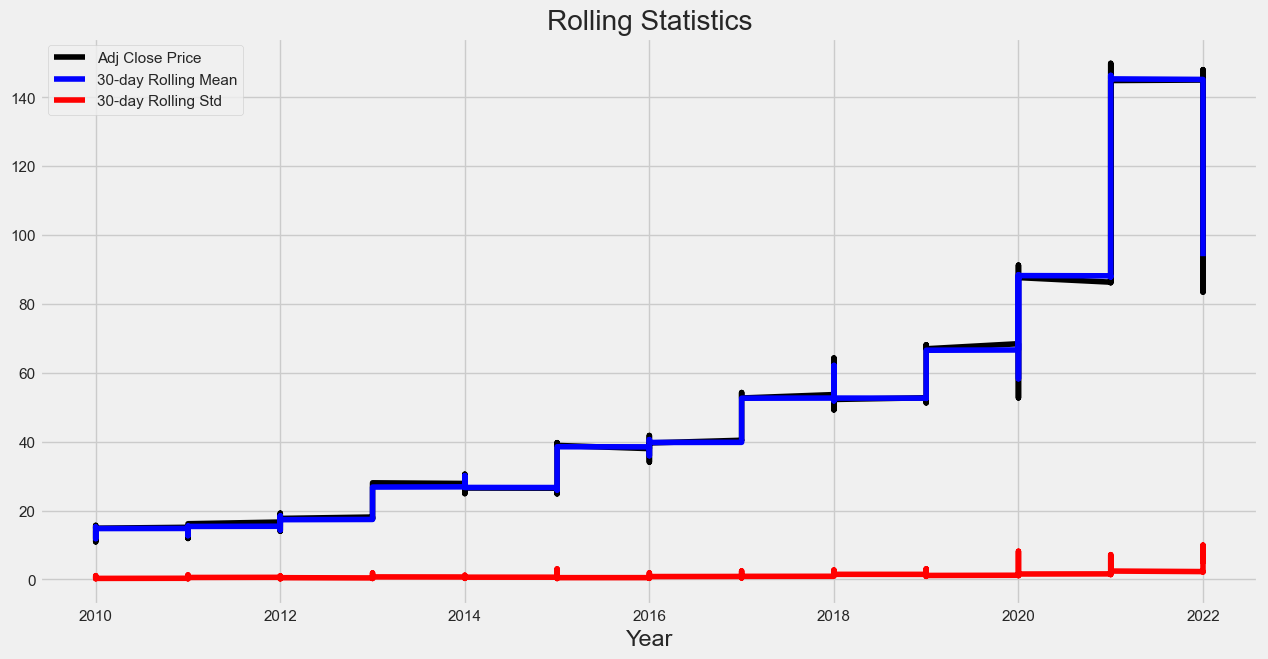

In [32]:
# Plot rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(google['Year'], google['Adj Close'], label='Adj Close Price', color='black')
plt.plot(google['Year'], rolling_mean, label=f'{rolling_window}-day Rolling Mean', color='blue')
plt.plot(google['Year'], rolling_std, label=f'{rolling_window}-day Rolling Std', color='red')
plt.xlabel('Year')
plt.title('Rolling Statistics')
plt.legend()
plt.show()

### Holt-Winter's Method

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### **Double Exponential Smoothening(Holt's Method)**

In [34]:
google['DES_add'] = ExponentialSmoothing(google['Adj Close'], trend = 'add').fit().fittedvalues.shift(-1)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



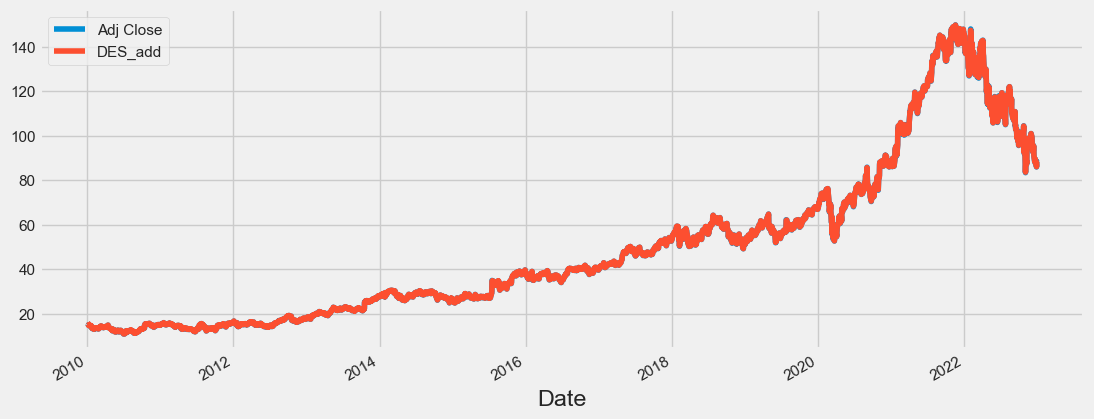

In [35]:
google[['Adj Close', 'DES_add']].plot(figsize=(12, 5));

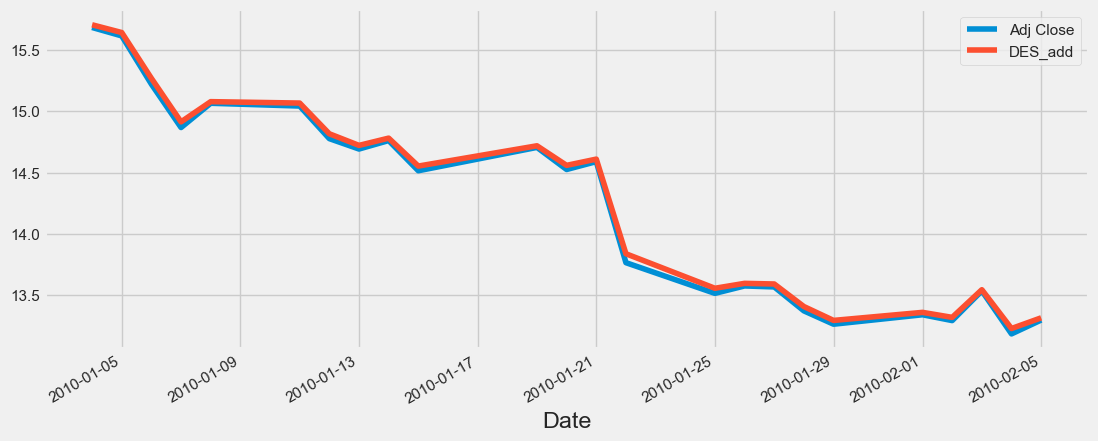

In [36]:
google[['Adj Close', 'DES_add']].iloc[:24].plot(figsize=(12, 5));

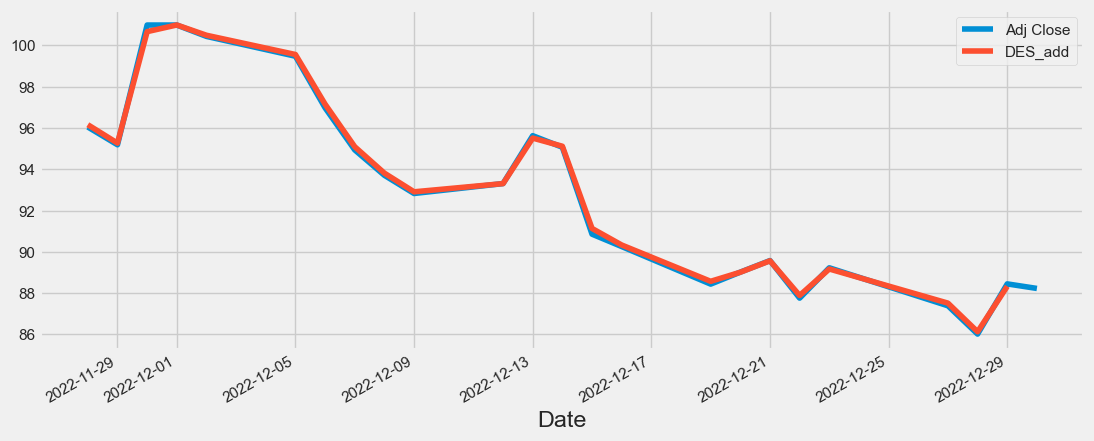

In [37]:
google[['Adj Close', 'DES_add']].iloc[-24:].plot(figsize=(12, 5));

In [38]:
### Checking the multiplicative model of this
google['DES_mul'] = ExponentialSmoothing(google['Adj Close'], trend = 'mul').fit().fittedvalues.shift(-1)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



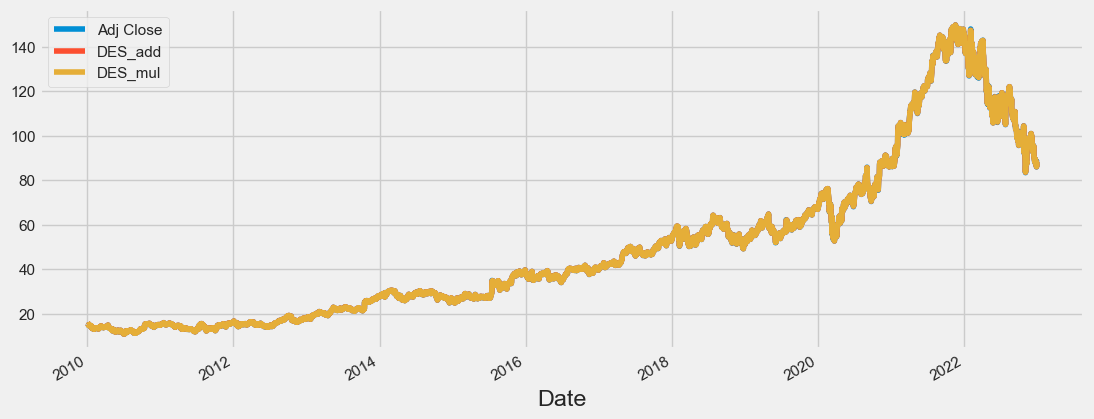

In [39]:
google[['Adj Close', 'DES_add', 'DES_mul']].plot(figsize=(12, 5));

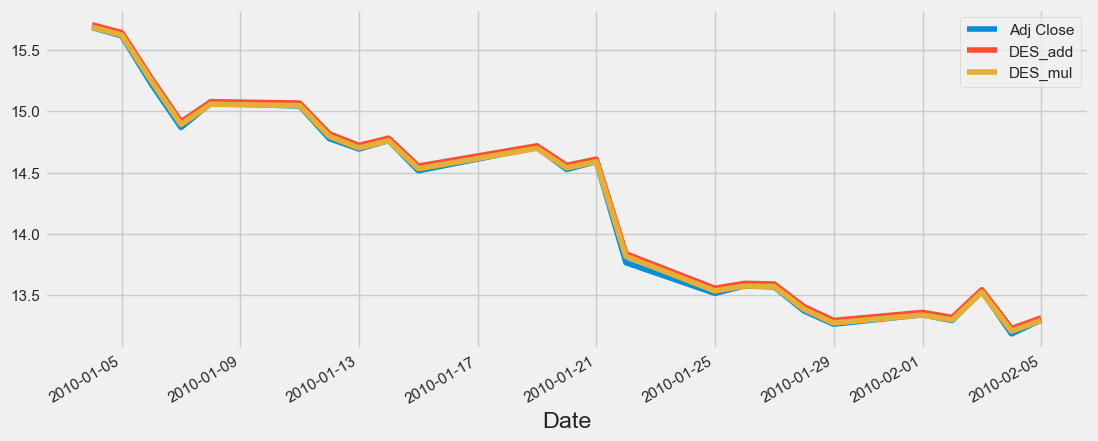

In [40]:
google[['Adj Close', 'DES_add', 'DES_mul']].iloc[:24].plot(figsize=(12, 5));

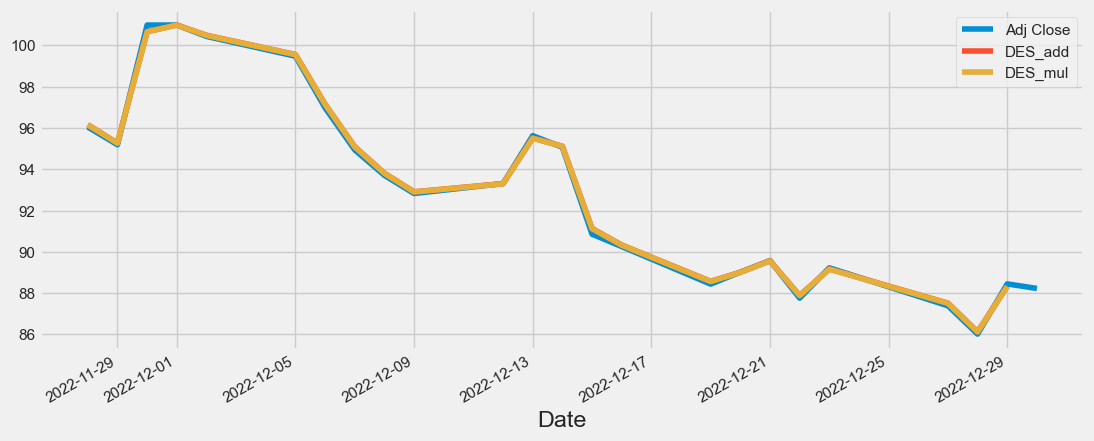

In [41]:
google[['Adj Close', 'DES_add', 'DES_mul']].iloc[-24:].plot(figsize=(12, 5));

#### In this case additive model of Double Exponential Smoothening is better than the multiplicative model

#### **Triple Exponential Smoothening(Holt-Winter's Method)**

In [42]:
google['TES_mul_12'] = ExponentialSmoothing(google['Adj Close'], trend = 'mul', seasonal='mul', seasonal_periods=24).fit().fittedvalues

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



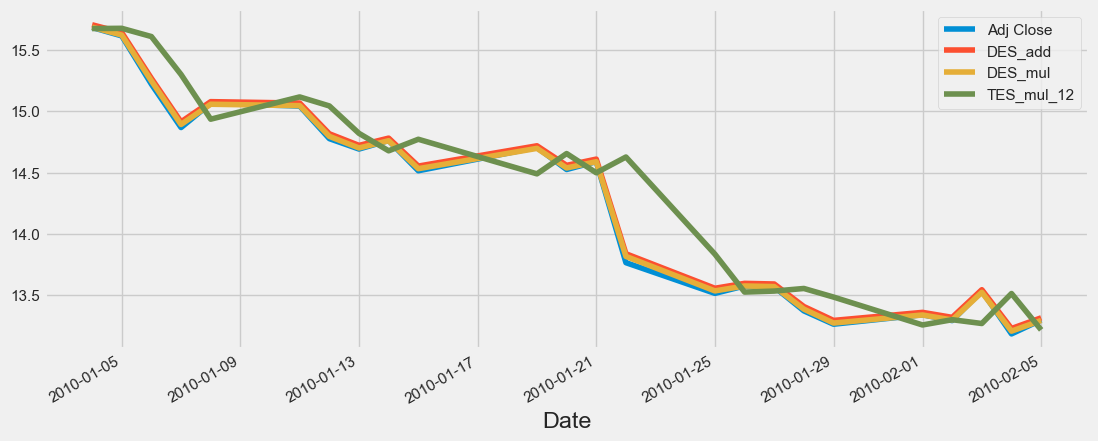

In [43]:
google[[ 'Adj Close','DES_add','DES_mul','TES_mul_12']].iloc[:24].plot(figsize=(12, 5));

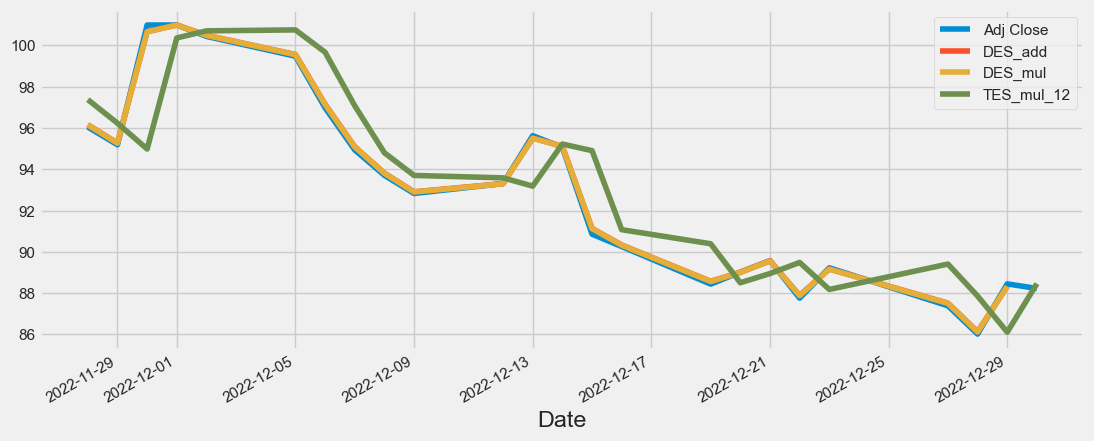

In [44]:
google[[ 'Adj Close','DES_add','DES_mul','TES_mul_12']].iloc[-24:].plot(figsize=(12, 5));

## Stationarity of Time Series Data

**To check the stationarity of the time series we will use the Augmented Dickey-Fuller Test**

In [45]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [46]:
adf_test(google['Adj Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.630788
p-value                    0.863872
# lags used               22.000000
# observations          3249.000000
critical value (1%)       -3.432364
critical value (5%)       -2.862430
critical value (10%)      -2.567244
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


**So the give data is not stationary over here, so we have to perform differencing in order to make it stationary**

In [47]:
### Performing differencing and applying dickey fuller test on it
from statsmodels.tsa.statespace.tools import diff
google['d1'] = diff(google['Adj Close'],k_diff=1)

In [48]:
adf_test(google['d1'],'1st Differencing Adj Close')

Augmented Dickey-Fuller Test: 1st Differencing Adj Close
ADF test statistic     -1.314387e+01
p-value                 1.411262e-24
# lags used             2.100000e+01
# observations          3.249000e+03
critical value (1%)    -3.432364e+00
critical value (5%)    -2.862430e+00
critical value (10%)   -2.567244e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**The data have become stationary on the first differencing**

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 

In [50]:
columns_to_drop = ['DES_add', 'DES_mul', 'TES_mul_12']
google.drop(columns=columns_to_drop, inplace=True)

In [51]:
# Drop rows with null values
google.dropna(inplace=True)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

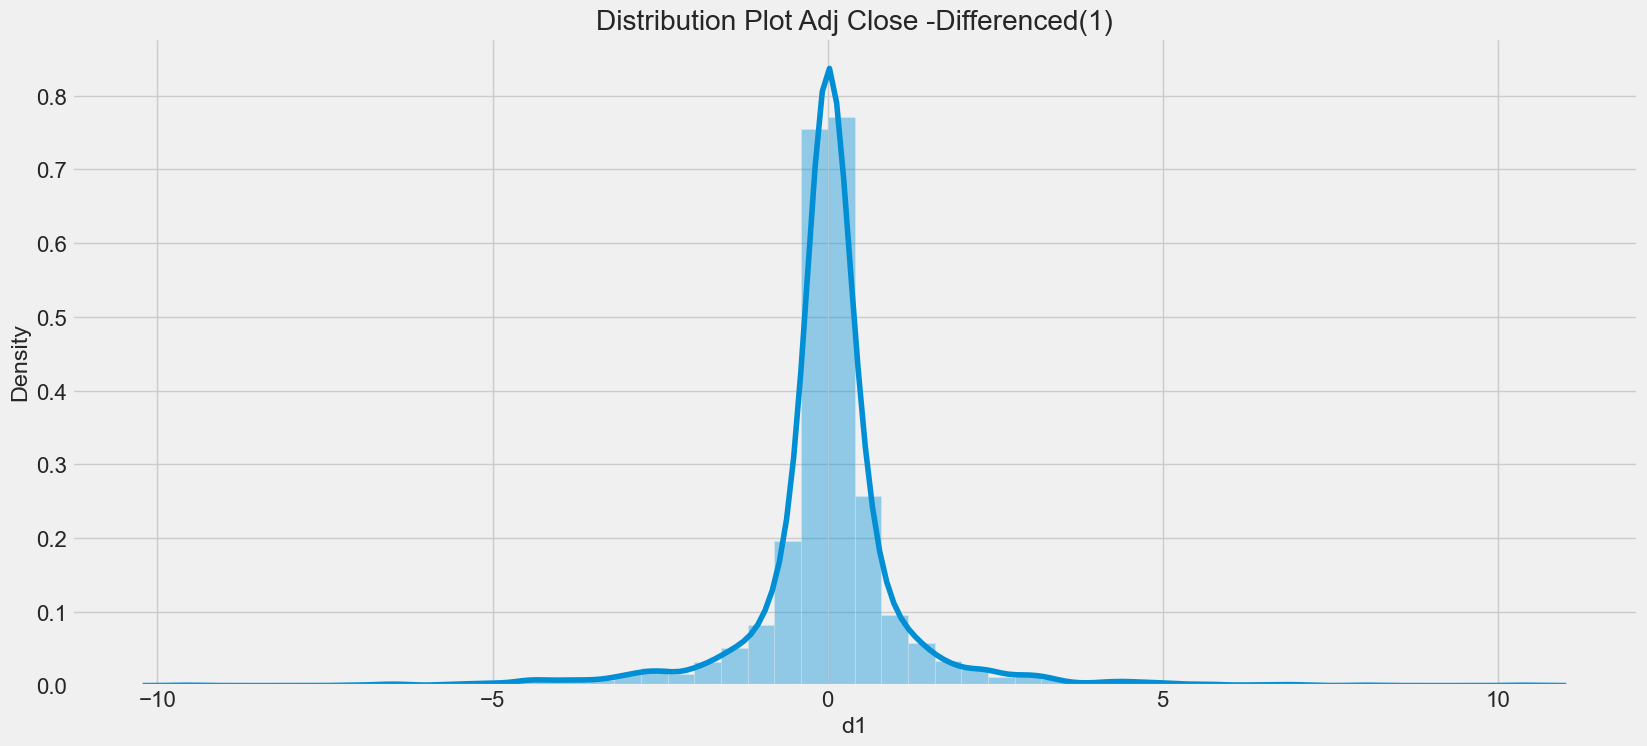

In [52]:
### Checking the distribution of the data
sns.distplot(google['d1']).set_title("Distribution Plot Adj Close -Differenced(1)")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Choosing and Modelling the ARIMA Models

In [53]:
# # Defining parameters for the grid search
# p_values = range(0, 6) # AR parameter
# d_values = range(0, 3) # Differencing parameter
# q_values = range(0, 6) # MA parameter

In [54]:
auto_arima(google['d1'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3271
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5028.562
Date:                Tue, 16 Apr 2024   AIC                          10063.125
Time:                        22:15:19   BIC                          10081.403
Sample:                             0   HQIC                         10069.671
                               - 3271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7140      0.055     13.054      0.000       0.607       0.821
ma.L1         -0.7649      0.051    -15.063      0.000      -0.864      -0.665
sigma2         1.2671      0.012    108.700      0.000       1.244       1.290
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             21226.00
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):              44.08   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
len(google)

3271

In [56]:
# Set one year for testing
train = google.iloc[:3205]
test = google.iloc[3205:]

In [68]:
model = sm.tsa.arima.ARIMA(google['Adj Close'], order=(1, 1, 1))
results = model.fit()
print(results.summary())

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3271
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5027.521
Date:                Tue, 16 Apr 2024   AIC                          10061.041
Time:                        22:29:22   BIC                          10079.319
Sample:                             0   HQIC                         10067.587
                               - 3271                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7142      0.055     13.062      0.000       0.607       0.821
ma.L1         -0.7650      0.051    -15.073      0.000      -0.865      -0.666
sigma2         1.2675      0.012    108.670      0.0

In [69]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,1) Predictions')

In [70]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Adj Close'][i]}")

predicted=97.66334049, expected=100.050003
predicted=100.0452708, expected=97.419998
predicted=97.55014026, expected=95.650002
predicted=95.83958793, expected=98.639999
predicted=98.6329673 , expected=101.639999
predicted=101.4820389, expected=101.43
predicted=101.3198353, expected=101.419998
predicted=101.3362267, expected=98.68
predicted=98.75526877, expected=97.860001
predicted=97.95928967, expected=97.18
predicted=97.29054445, expected=97.559998
predicted=97.62524176, expected=99.059998
predicted=99.03362155, expected=96.559998
predicted=96.66696956, expected=99.970001
predicted=99.8784047 , expected=100.769997
predicted=100.6592345, expected=99.629997
predicted=99.6032403 , expected=99.970001
predicted=99.93223848, expected=101.129997
predicted=101.0421097, expected=102.519997
predicted=102.3820643, expected=104.480003
predicted=104.2747931, expected=94.93
predicted=95.25872207, expected=92.220001
predicted=92.60931648, expected=96.290001
predicted=96.38084052, expected=94.510002


In [80]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Adj Close'], predictions)
print(f'ARIMA(1,0,1)) MSE Error: {error:11.10}')

ARIMA(1,0,1)) MSE Error: 6.170843032


In [81]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Adj Close'], predictions)
print(f'SARIMA(1,0,1) RMSE Error: {error:11.10}')

SARIMA(1,0,1) RMSE Error:  2.48411816


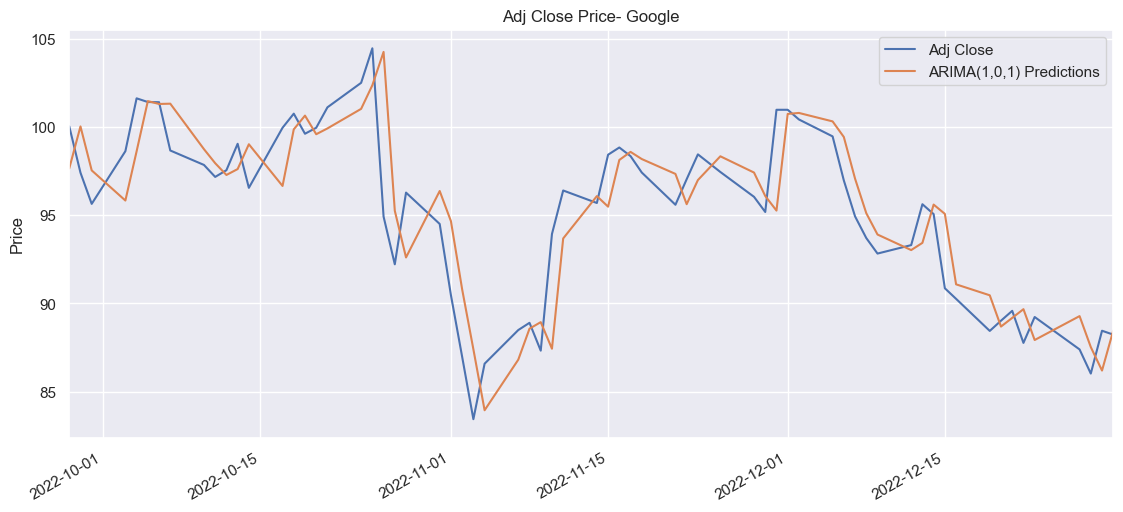

In [74]:
# Plot predictions against known values
title = 'Adj Close Price- Google'
ylabel='Price'
xlabel=''

ax = test['Adj Close'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## LSTMs Model

In [82]:
from tensorflow.keras.optimizers import Adam

In [83]:
# Extract the 'close' price column
close_price = google['Adj Close'].values.reshape(-1, 1)

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_price_scaled = scaler.fit_transform(close_price)

In [85]:
# Split the data into training and testing sets
train_size = int(len(close_price_scaled) * 0.8)
test_size = len(close_price_scaled) - train_size
train_data, test_data = close_price_scaled[0:train_size,:], close_price_scaled[train_size:len(close_price_scaled),:]

In [87]:
# Function to create dataset with look back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30  # Number of time steps to look back
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

In [88]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [89]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

In [90]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100

81/81 - 6s - loss: 0.0014 - val_loss: 0.0059 - 6s/epoch - 69ms/step
Epoch 2/100
81/81 - 0s - loss: 1.6479e-04 - val_loss: 0.0058 - 310ms/epoch - 4ms/step
Epoch 3/100
81/81 - 0s - loss: 1.5380e-04 - val_loss: 0.0057 - 307ms/epoch - 4ms/step
Epoch 4/100
81/81 - 0s - loss: 1.3462e-04 - val_loss: 0.0049 - 301ms/epoch - 4ms/step
Epoch 5/100
81/81 - 0s - loss: 1.2375e-04 - val_loss: 0.0047 - 305ms/epoch - 4ms/step
Epoch 6/100
81/81 - 0s - loss: 1.1344e-04 - val_loss: 0.0032 - 299ms/epoch - 4ms/step
Epoch 7/100
81/81 - 0s - loss: 9.5543e-05 - val_loss: 0.0041 - 315ms/epoch - 4ms/step
Epoch 8/100
81/81 - 0s - loss: 8.7901e-05 - val_loss: 0.0040 - 305ms/epoch - 4ms/step
Epoch 9/100
81/81 - 0s - loss: 7.1014e-05 - val_loss: 0.0031 - 302ms/epoch - 4ms/step
Epoch 10/100
81/81 - 0s - loss: 6.5103e-05 - val_loss: 0.0046 - 305ms/epoch - 4ms/step
Epoch 11/100
81/81 - 0s - loss: 6.0145e-05 - val_loss: 0.0043 - 311ms/epoch - 4ms/step
Epoch 12/100
81/81 - 0s - loss: 5.7227e-05 - val_loss: 0.

In [91]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

20/20 [==============================] - 0s 3ms/step


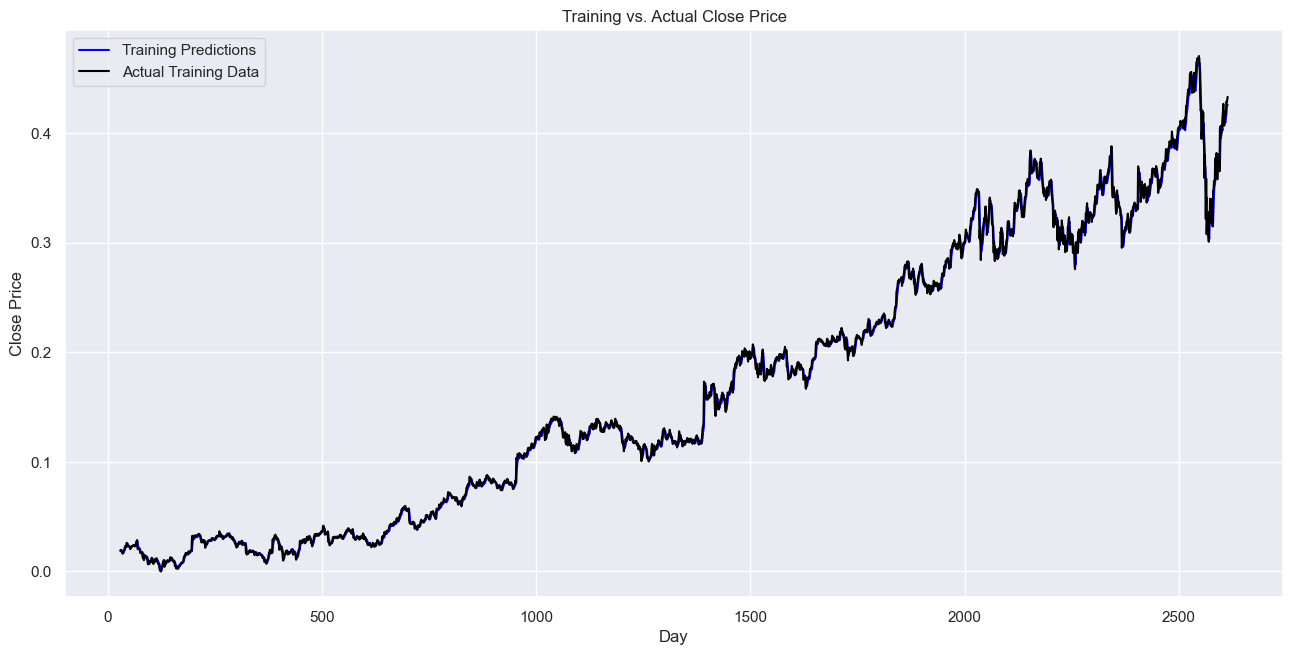

In [92]:
# Plot training vs. actual
plt.figure(figsize=(14, 7))
plt.plot(np.arange(look_back, len(train_predict) + look_back), train_predict.ravel(), label='Training Predictions', color='blue')
plt.plot(np.arange(look_back, len(train_predict) + look_back), Y_train.ravel(), label='Actual Training Data', color='black')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Training vs. Actual Close Price')
plt.legend()
plt.show()

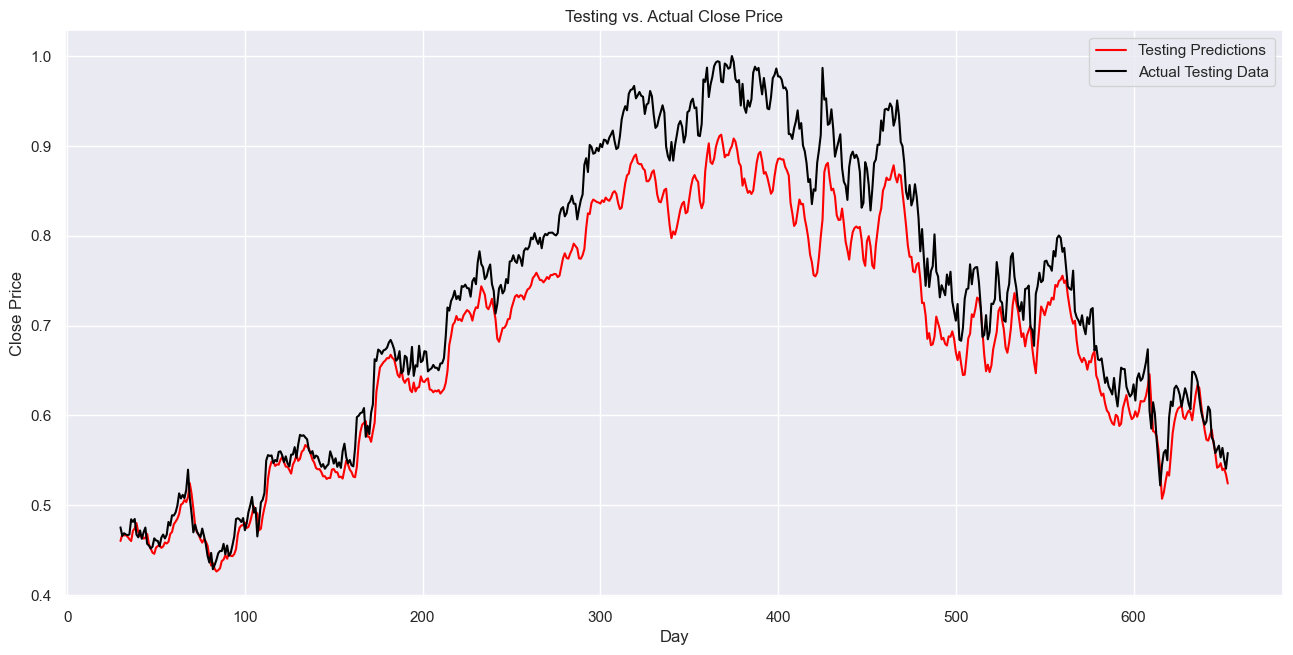

In [93]:
# Plot testing vs. actual
plt.figure(figsize=(14, 7))
plt.plot(np.arange(look_back, len(test_predict) + look_back), test_predict.ravel(), label='Testing Predictions', color='red')
plt.plot(np.arange(look_back, len(test_predict) + look_back), Y_test.ravel(), label='Actual Testing Data', color='black')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Testing vs. Actual Close Price')
plt.legend()
plt.show()

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(Y_train.ravel(), train_predict.ravel())
train_mse = mean_squared_error(Y_train.ravel(), train_predict.ravel())
train_rmse = np.sqrt(train_mse)

test_mae = mean_absolute_error(Y_test.ravel(), test_predict.ravel())
test_mse = mean_squared_error(Y_test.ravel(), test_predict.ravel())
test_rmse = np.sqrt(test_mse)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_rmse}")

print("\nTesting Metrics:")
print(f"MAE: {test_mae}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse}")

Training Metrics:
MAE: 0.003222055791291871
MSE: 2.50765626813188e-05
RMSE: 0.005007650415246536

Testing Metrics:
MAE: 0.04435350255109939
MSE: 0.0029880226001869005
RMSE: 0.054662808198874126
